In [34]:
import datetime
import locale
import random as rd
import re
from typing import List, Tuple

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import seaborn as sns
import spacy
import unidecode
from bokeh.transform import factor_cmap
from datasets import Dataset, DatasetDict
from gensim import corpora, models
from gensim.models import CoherenceModel, Phrases, word2vec
from gensim.models.phrases import Phraser
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error
from sklearn.model_selection import train_test_split
from transformers import (AutoModelForSequenceClassification, AutoTokenizer,
                          DataCollatorWithPadding, Trainer, TrainingArguments,
                          pipeline)
from xgboost import XGBClassifier


# Chargement + exploration data


In [273]:
df = pd.read_csv("./avisassurance_train.csv", sep=";", low_memory=False)


In [43]:
df_test = pd.read_csv("./avisassurance_test.csv", sep=";", low_memory=False)

In [44]:
df_test.describe()

,date,auteur,avis,assureur,produit
count,10332,10332,10331,10332,10332
unique,1732,10238,10322,56,13
top,01 septem...,laura-80757,Intervention supprimée à la demande de l'inter...,Direct Assurance,auto
freq,48,3,6,2607,6082


In [45]:
df.describe()

,note
count,24105.000000
mean,2.847583
std,1.531368
min,1.000000
25%,1.000000
50%,3.000000
75%,4.000000
max,5.000000


In [ ]:
# Parse date into datetime object
locale.setlocale(locale.LC_ALL, "fr_FR.utf8")
df.date = df.date.apply(
    lambda x: datetime.datetime.strptime(x.split("suite")[0].strip(), "%d %B %Y")
)

df_test.date = df_test.date.apply(
    lambda x: datetime.datetime.strptime(x.split("suite")[0].strip(), "%d %B %Y")
)


In [22]:
df.head()


,date,note,auteur,avis,assureur,produit
0,2021-09-06,5,brahim--k-131532,"Meilleurs assurances, prix, solutions, écoute,...",Direct Assurance,auto
1,2021-05-03,4,bernard-g-112497,"je suis globalement satisfait , sauf que vous ...",Direct Assurance,auto
2,2021-03-21,5,virginie-t-107352,Prix tres abordable plusieurs options s'offren...,Direct Assurance,auto
3,2021-06-10,4,boulain-f-116580,"je satisfait du service, une réponse très rapi...",L'olivier Assurance,auto
4,2017-01-29,1,ouaille31-51798,"Client depuis plus de 25 ans, très déçu de cet...",Matmut,auto


<AxesSubplot:>

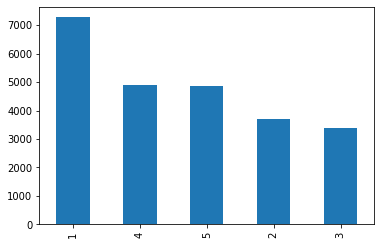

In [12]:
df.note.value_counts().plot(kind="bar")


<AxesSubplot:>

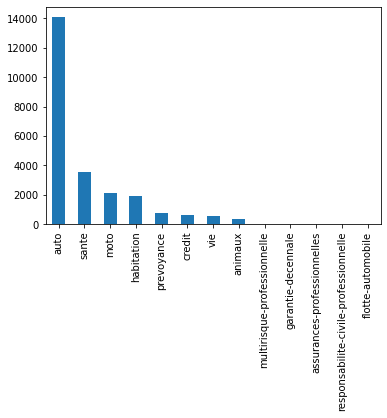

In [13]:
df.produit.value_counts().plot(kind="bar")


<AxesSubplot:>

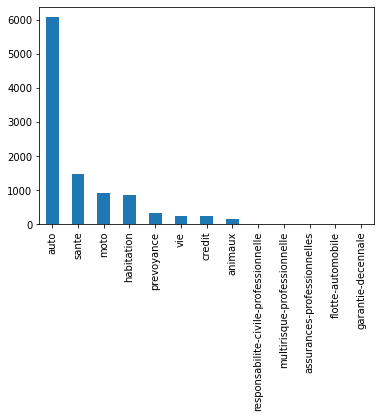

In [15]:
df_test.produit.value_counts().plot(kind="bar")


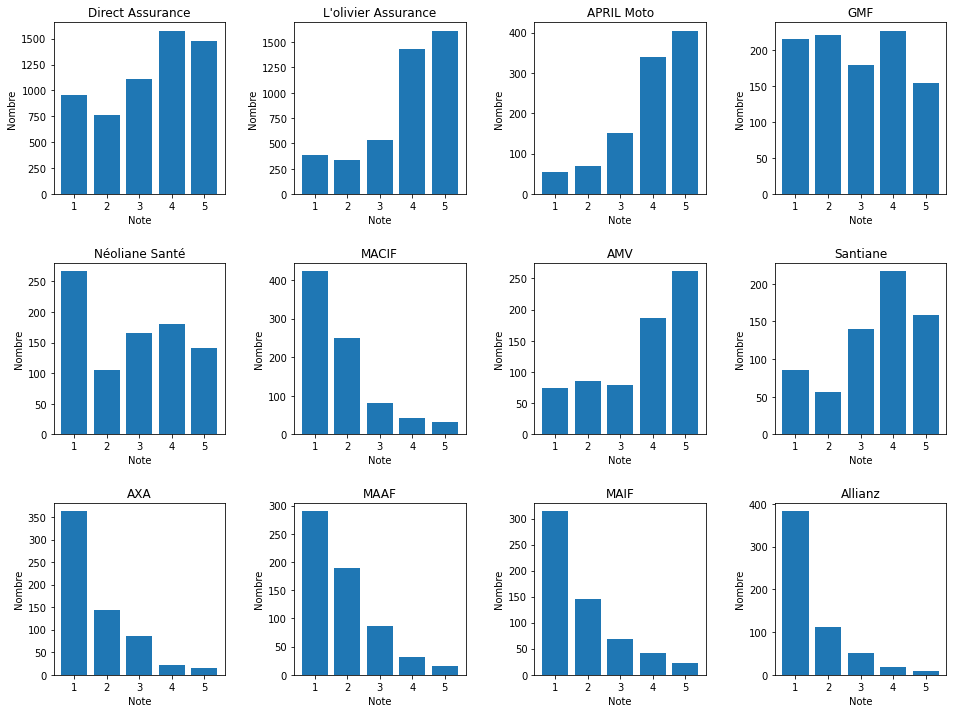

In [8]:
top12 = df.assureur.value_counts()[:12]

# Draw 12 subplots, with distribution of note for each assureur
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 12))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
for i, ax in enumerate(axes.flat):
    ax.set_title(top12.index[i])
    ax.set_xlabel("Note")
    ax.set_ylabel("Nombre")
    ax.set_xticks(range(1, 6))
    ax.bar(
        range(1, 6),
        height=df[df.assureur == top12.index[i]].note.value_counts().sort_index(),
    )


In [275]:
df.dropna(subset=["avis"], inplace=True)
df_test.dropna(subset=["avis"], inplace=True)


In [48]:
reviews = df.avis.to_list()
rd.shuffle(reviews, rd.seed(11))
len(reviews), reviews[0]


(24104,
 "Les prix semblent très corrects par rapport a mon ancienne assurance, et la démarche est très simple. Reste maintenant a voir dans la pratique. Mais pour l'instant, je suis plutôt satisfaite")

# Preprocessing pour LDA


## Preprocessing

Tokenization, nettoyage, bigrams/trigrams


In [6]:
fr_stop = set(stopwords.words("french"))
fr_stop.update({"a", "les"})


def preprocess_texts(texts: List[str]) -> List[List[str]]:
    """
    Preprocess texts and remove stopwords.
    Remove punctuation and numbers.
    Keeps only nouns, adjectives, verbs and adverbs.
    Args:
      texts: List of texts to preprocess.

    Returns:
      tokens: List of tokens for each text.
    """
    tokens: List[List[str]] = []
    punctuation = r'!"#$%&\'’*+-.,/:;<=>?()[]{}@\^_`|~0123456789' + "\r\n"
    t = str.maketrans(dict.fromkeys(punctuation, " "))
    # remove punctuation
    texts = [doc.translate(t) for doc in texts]
    # remove accents
    texts = [unidecode.unidecode(doc) for doc in texts]
    # set to lowercase
    texts = [doc.lower() for doc in texts]
    # tokenize with nltk
    tokens = [word_tokenize(doc) for doc in texts]
    # remove tokens with length < 3
    tokens = [[word for word in doc if len(word) >= 3] for doc in tokens]
    # remove stopwords
    tokens = [[word for word in doc if word not in fr_stop] for doc in tokens]
    return tokens


tokenized_reviews = preprocess_texts(reviews)


In [7]:
print(tokenized_reviews[0])


['prix', 'semblent', 'tres', 'corrects', 'rapport', 'ancienne', 'assurance', 'demarche', 'tres', 'simple', 'reste', 'maintenant', 'voir', 'pratique', 'instant', 'plutot', 'satisfaite']


In [8]:
def create_bigrams_trigrams(documents: List[List[str]]) -> Tuple[Phraser, Phraser]:
    """
    Create bigrams and trigrams from a list of documents.
    Args:
      documents: List of tokenized documents.

    Returns:
      bigram: Phraser object for bigrams.
      trigram: Phraser object for trigrams.
    """
    bigram = Phrases(documents, min_count=5, threshold=100)
    trigram = Phrases(bigram[documents], min_count=5, threshold=100)
    bigram_mod = Phraser(bigram)
    trigram_mod = Phraser(trigram)
    return bigram_mod, trigram_mod


bigram_mod, trigram_mod = create_bigrams_trigrams(tokenized_reviews)


## Lemmatization


In [9]:
# Initialize spacy 'fr_core_news_lg' model, keeping only tagger component (for efficiency)
nlp = spacy.load("fr_core_news_lg", disable=["parser", "ner"])


def lemmatize_bigrams_trigrams(
    tokenized_texts,
    do_lemmatization: bool = True,
    allowed_postags: List[str] = ["NOUN", "ADJ", "VERB", "ADV"],
):
    """
    Create bigrams and trigrams from a list of tokenized texts.
    Lemmatizes and removes stopwords from the result.
    Args:
      tokenized_texts: List of tokenized texts.
      allowed_postags: List of allowed parts of speech.

    Returns:
      texts_out: List of lemmatized texts with bigrams/trigrams.
    """
    bigrams = [bigram_mod[doc] for doc in tokenized_texts]
    trigrams = [trigram_mod[bigram_mod[doc]] for doc in bigrams]
    if do_lemmatization:
        texts_out = []
        for sent in trigrams:
            doc = nlp(" ".join(sent))
            texts_out.append(
                [token.lemma_ for token in doc if token.pos_ in allowed_postags]
            )
        return texts_out
    return trigrams


In [32]:
# Do lemmatization keeping only noun, adj, vb, adv
data_final = lemmatize_bigrams_trigrams(tokenized_reviews, do_lemmatization=True)


In [33]:
print(data_final[2])


['assez', 'satisfait', 'ensemble', 'prix', 'correct', 'peu', 'decu', 'formule', 'tous_risque', 'meme', 'reste', 'assez', 'eleve', 'sinon', 'concerner', 'autre', 'formule']


In [ ]:
trigrams = set()
r = re.compile(".*_.*_.*")
for review in data_final:
    for word in review:
        if re.match(r, word):
            trigrams.add(word)

print(trigrams)


{'personne_bout_fil', 'lettre_mise_demeure', 'regard_politique_acceptation', 'pare_choc_arriere', 'cadre_loi_hamon', 'carte_verte_definitive', 'merci_bonne_continuation', 'aujourd_hui_recois', 'valoir_droit_retractation', 'nombreux_appels_telephoniques', 'risque_pack_serenite', 'toutes_pieces_justificatives', 'aujourd_hui_toujours', 'recois_aujourd_hui', 'nouvelle_carte_verte', 'prise_charge_hospitaliere', 'envoie_carte_verte', 'encore_aujourd_hui', 'aujourd_hui_courrier', 'franchise_bris_glace', 'aujourd_hui_meme', 'assure_tous_risques', 'conge_longue_maladie', 'avant_date_anniversaire', 'veritable_parcours_combattant', 'moment_rien_redire', 'ans_aujourd_hui', 'jours_aujourd_hui', 'reception_carte_verte', 'janvier_aujourd_hui', 'maif_assureur_militant', 'grand_importe_quoi', 'carte_verte_provisoire', 'assuree_tous_risques', 'reponses_questions_posees', 'aujourd_hui_mois', 'petit_degat_eaux', 'suite_bris_glace', 'bla_bla_bla', 'aujourd_hui_juillet', 'aujourd_hui_car', 'heure_aujourd_hu

## LDA


In [34]:
# Run LDA on cleaned documents
id2word = corpora.Dictionary(data_final)
corpus = [id2word.doc2bow(cleandoc) for cleandoc in data_final]


In [44]:
NUM_TOPICS = 2

ldamodel = models.ldamulticore.LdaMulticore(
    corpus,
    num_topics=NUM_TOPICS,
    id2word=id2word,
    chunksize=2200,
    passes=5,
    alpha="symmetric",
    per_word_topics=True,
    workers=10,
)

print(ldamodel.print_topics(num_topics=NUM_TOPICS, num_words=6))


[(0, '0.024*"assurance" + 0.015*"plus" + 0.013*"faire" + 0.010*"contrat" + 0.009*"mois" + 0.009*"dire"'), (1, '0.021*"service" + 0.020*"prix" + 0.016*"assurance" + 0.014*"tres" + 0.013*"satisfait" + 0.011*"tre"')]


In [45]:
coherence_model_lda = CoherenceModel(
    model=ldamodel, texts=data_final, dictionary=id2word, coherence="c_v"
)
print("Perplexity: ", ldamodel.log_perplexity(corpus))
coherence_lda = coherence_model_lda.get_coherence()
print("Coherence Score: ", coherence_lda)

# No lemmatization, trigrams, alpha symmetric, workers 10, passes 5, chunksize 2000
# Perplexity:  -7.348628298906403
# Coherence Score:  0.45756247328560756


Perplexity:  -7.286237582782422
Coherence Score:  0.4082616050504262


In [46]:
pyLDAvis.enable_notebook()
gensimvis.prepare(ldamodel, corpus, id2word)


C:\Users\Maxime\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.048663  0.0       1        1  65.782209
1     -0.048663  0.0       2        1  34.217791, topic_info=          Term         Freq        Total Category  logprob  loglift
8         prix  5439.000000  5439.000000  Default  30.0000  30.0000
44     service  7118.000000  7118.000000  Default  29.0000  29.0000
36   satisfait  3599.000000  3599.000000  Default  28.0000  28.0000
14        tres  4150.000000  4150.000000  Default  27.0000  27.0000
187        tre  3631.000000  3631.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
15        voir   895.507795  2102.714317   Topic2  -5.4686   0.2188
265    dossier   979.493727  2723.432484   Topic2  -5.3790   0.0498
123   sinistre  1112.061602  4456.744062   Topic2  -5.2520  -0.3158
124   toujours   948.250279  3303.596612   Topic2  -5.4114  -0.1757
142       mois   937.710148  4700.911295   Topic2  -5.4226  -0.5396

[218 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
389        1  0.049385  abordable
389        2  0.950659  abordable
831        1  0.807773   accident
831        2  0.191991   accident
63         1  0.167748    accueil
...      ...       ...        ...
125        2  0.170518    voiture
955        1  0.904781        vol
955        2  0.095834        vol
10705      1  0.076960  volontier
10705      2  0.923523  volontier

[348 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

## Visualisation des phrases et clusters


In [47]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_dict = {}

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, _ in wp])
                sent_topics_dict[i] = [
                    int(topic_num),
                    round(prop_topic, 4),
                    topic_keywords,
                ]
            else:
                break
    sent_topics_df = pd.DataFrame.from_dict(
        sent_topics_dict,
        orient="index",
        columns=["Dominant_Topic", "Perc_Contribution", "Topic_Keywords"],
    )

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return sent_topics_df


In [48]:
df_topic_sents_keywords = format_topics_sentences(
    ldamodel=ldamodel, corpus=corpus, texts=data_final
)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = [
    "Document_No",
    "Dominant_Topic",
    "Topic_Perc_Contrib",
    "Keywords",
    "Text",
]
df_dominant_topic.head(10)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1,0.9655,"service, prix, assurance, tres, satisfait, tre...","[prix, sembler, tres, correct, rapport, ancien..."
1,1,0,0.7922,"assurance, plus, faire, contrat, mois, dire, s...","[fuir, competer, remboursement, parler, choix,..."
2,2,1,0.9617,"service, prix, assurance, tres, satisfait, tre...","[assez, satisfait, ensemble, prix, correct, pe..."
3,3,1,0.9541,"service, prix, assurance, tres, satisfait, tre...","[satisfait, rapport, exigence, prix, correct, ..."
4,4,1,0.9777,"service, prix, assurance, tres, satisfait, tre...","[bon, prix, simple, pratique, satisfait, servi..."
5,5,1,0.9548,"service, prix, assurance, tres, satisfait, tre...","[recu, emelin, jour, accueil, point, parfait, ..."
6,6,0,0.8244,"assurance, plus, faire, contrat, mois, dire, s...","[harmonie, mutuel, refuse, faire, photocopie, ..."
7,7,1,0.9525,"service, prix, assurance, tres, satisfait, tre...","[satisfait, prix, devis, beaucoup, moins, cher..."
8,8,1,0.7950,"service, prix, assurance, tres, satisfait, tre...","[satisfait, assurance, auto, direct, assurance..."
9,9,1,0.5991,"service, prix, assurance, tres, satisfait, tre...","[assure, an, reste, satisfait, service, voitur..."


## t-SNE du modèle LDA


In [49]:
# Get topic weights
topic_weights = []
for i, row_list in enumerate(ldamodel[corpus]):
    topic_weights.append([w for _, w in row_list[0]])

# Array of topic weights
arr = pd.DataFrame(topic_weights).fillna(0)

# Dominant topic number in each doc
arr["topic_num"] = arr.apply(lambda row: np.argmax(row), axis=1)

In [52]:
# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, n_jobs=10, init="pca", learning_rate="auto", perplexity=100, n_iter=500)
tsne_lda = tsne_model.fit_transform(arr.iloc[:, :-1], arr.iloc[:, -1:])

# Add 2 columns from the values of tsne_lda
arr["tsne-x"], arr["tsne-y"] = tsne_lda[:, 0], tsne_lda[:, 1]
arr.columns = ["prop_0", "prop_1", "topic_num", "tsne-x", "tsne-y"]

C:\Users\Maxime\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


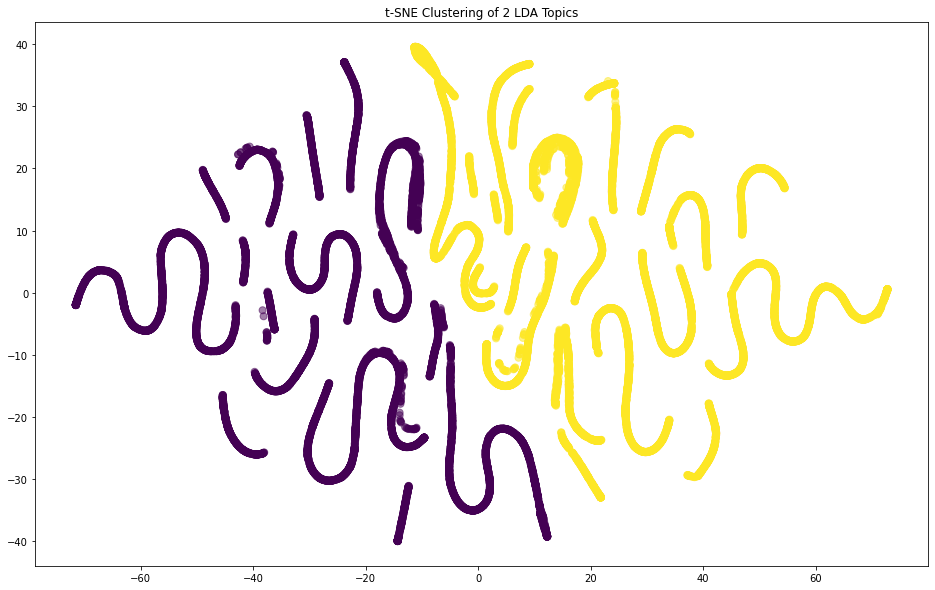

In [53]:
# colors map
mycolors = [color for _, color in mcolors.TABLEAU_COLORS.items()]
index_cmap = factor_cmap(
    "topic_num", palette=mycolors, factors=list(map(str, range(NUM_TOPICS)))
)

# bokeh scatter plot from arr tsne-x and tsne-y
plt.figure(figsize=(16, 10))
plt.title(f"t-SNE Clustering of {NUM_TOPICS} LDA Topics")
plt.scatter(
    arr["tsne-x"], arr["tsne-y"], c=arr["topic_num"], s=50, alpha=0.5
)
plt.legend.location = "top_left"

plt.show()


# Word2Vec


## Preprocessing et modèle


In [54]:
def preprocess_word2vec(texts: List[str]) -> List[List[str]]:
    # remove accents
    texts = [unidecode.unidecode(doc) for doc in texts]
    # remove special characters
    texts = [re.sub("[^A-Za-z0-9]", " ", doc) for doc in texts]
    # set to lowercase
    texts = [doc.lower() for doc in texts]
    # tokenize with nltk
    tokens = [word_tokenize(doc) for doc in texts]
    # remove tokens with length < 3
    tokens = [[word for word in doc if len(word) > 3] for doc in tokens]
    return tokens


w2v_corpus = preprocess_word2vec(reviews)
data_final = lemmatize_bigrams_trigrams(w2v_corpus, do_lemmatization=False)


In [55]:
# flatten data_final to a list
words = [word for sublist in data_final for word in sublist]
words[:10]

['prix',
 'semblent',
 'tres',
 'corrects',
 'rapport',
 'ancienne',
 'assurance',
 'demarche',
 'tres',
 'simple']

In [83]:
model = word2vec.Word2Vec(
    w2v_corpus,
    vector_size=600,
    window=20,
    min_count=20,
    workers=10,
    sg=1,
    negative=10,
    ns_exponent=0.75,
    epochs=3,
)


In [59]:
model.wv.similarity("allianz", "maif")


0.414773

In [91]:
model.wv.most_similar("maif")


[('militant', 0.6529897451400757),
 ('societaire', 0.6076914668083191),
 ('etage', 0.5954101085662842),
 ('bois', 0.5935847759246826),
 ('douche', 0.5917180180549622),
 ('orage', 0.5907077193260193),
 ('commune', 0.5892978310585022),
 ('grille', 0.5889892578125),
 ('piscine', 0.5871814489364624),
 ('pluie', 0.5863705277442932)]

## t-SNE du modèle Word2Vec


In [86]:
# Filter the list of vectors to include only those that Word2Vec has a vector for
vector_list = [model.wv[word] for word in words if word in model.wv]

# Create a list of the words corresponding to these vectors
words_filtered = [word for word in words if word in model.wv]

# Zip the words together with their vector representations
word_vec_zip = zip(words_filtered, vector_list)

# Cast to a dict so we can turn it into a DataFrame
word_vec_dict = dict(word_vec_zip)
df_w2v = pd.DataFrame.from_dict(word_vec_dict, orient='index')
df_w2v.head(3)

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
prix,0.212855,-0.048964,-0.088163,0.032093,-0.069143,0.015557,0.025530,0.103791,0.121265,0.148947,...,-0.087057,0.128361,0.038060,-0.055669,-0.089180,0.013153,-0.164528,0.039920,0.047450,-0.157191
semblent,0.115134,0.003772,-0.215613,0.044682,-0.064333,-0.023739,0.101985,0.104514,0.122871,0.049318,...,0.048136,0.016530,0.068612,-0.102039,0.137003,0.106695,-0.162042,-0.165213,0.039048,-0.145602
tres,0.064099,0.022777,-0.060385,-0.018224,-0.091916,0.031904,0.221007,0.089552,0.144951,0.050392,...,-0.143529,-0.095320,0.043064,-0.021109,0.024039,0.065401,0.033994,-0.050305,0.051511,-0.053372


In [89]:
tsne = TSNE(n_components=2, init="random", perplexity=1000, n_iter=10000, learning_rate='auto')

# Use only 400 rows to shorten processing time
tsne_df = tsne.fit_transform(df_w2v[:200])


C:\Users\Maxime\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


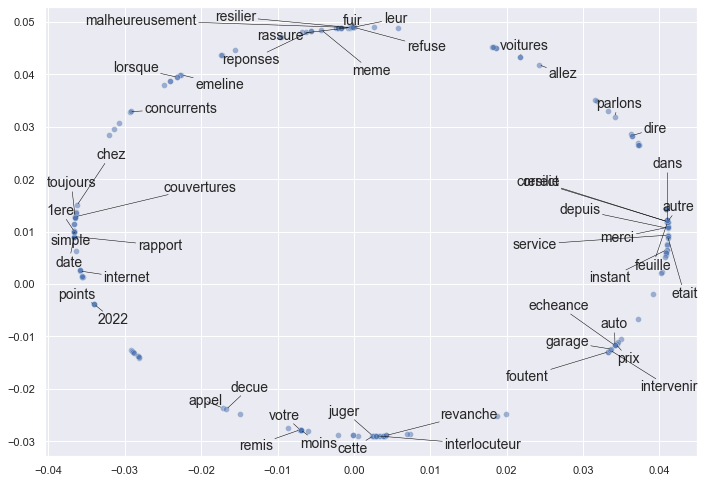

In [90]:
sns.set()
# Initialize figure
fig, ax = plt.subplots(figsize=(11.7, 8.27))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha=0.5)

# Import adjustText, initialize list of texts
from adjustText import adjust_text

texts = []
# select 50 words to annotate
words_to_plot = np.linspace(0, 200, 50, dtype=int, endpoint=False)

# Append words to list
for word in words_to_plot:
    texts.append(
        plt.text(tsne_df[word, 0], tsne_df[word, 1], df_w2v.index[word], fontsize=14)
    )

# Plot text using adjust_text (because overlapping text is hard to read)
adjust_text(
    texts,
    force_points=0.4,
    force_text=0.4,
    expand_points=(2, 1),
    expand_text=(1, 2),
    arrowprops=dict(arrowstyle="-", color="black", lw=0.5),
)

plt.show()


# Prédiction de note avec BERT (huggingface)


## Import du modèle huggingface

_nlptown/bert-base-multilingual-uncased-sentiment_


In [262]:
tokenizer = AutoTokenizer.from_pretrained(
    "nlptown/bert-base-multilingual-uncased-sentiment"
)

model = AutoModelForSequenceClassification.from_pretrained(
    "nlptown/bert-base-multilingual-uncased-sentiment", num_labels=5
)


## Tests sur quelques phrases


In [9]:
test = tokenizer(reviews[0])
reviews[0]


"Les prix semblent très corrects par rapport a mon ancienne assurance, et la démarche est très simple. Reste maintenant a voir dans la pratique. Mais pour l'instant, je suis plutôt satisfaite"

In [10]:
tokenizer.decode(test["input_ids"])


"[CLS] les prix semblent tres corrects par rapport a mon ancienne assurance, et la demarche est tres simple. reste maintenant a voir dans la pratique. mais pour l'instant, je suis plutot satisfaite [SEP]"

In [263]:
multilang_classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)


In [286]:
sample = df[:100]
sample["avis"] = sample["avis"].str.slice(0, 512)
reviews_sample = sample.avis.to_list()
results = multilang_classifier(reviews_sample)
results_stars = [int(x["label"][0]) for x in results]


C:\Users\Maxime\AppData\Local\Temp/ipykernel_14300/2001803892.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample["avis"] = sample["avis"].str.slice(0, 512)


In [287]:
mean_squared_error(sample.note, results_stars, squared=False)

0.9

In [29]:
f1_score(sample["note"].to_list(), results_stars, average="weighted"), accuracy_score(
    sample["note"], results_stars
)


(0.4576087575259989, 0.48)

## Création d'un _dataset_ à partir de nos données


In [11]:
train, test = train_test_split(df, test_size=0.2)
train = train[["avis", "note"]]
test = test[["avis", "note"]]

train["text"] = train["avis"]
test["text"] = test["avis"].str[:512]

train["label"] = train["note"].apply(lambda x: x - 1)
test["label"] = test["note"].apply(lambda x: x - 1)

train.drop(["avis", "note"], inplace=True, axis=1)
test.drop(["avis", "note"], inplace=True, axis=1)

train = Dataset.from_pandas(train)
test = Dataset.from_pandas(test)

train = train.remove_columns("__index_level_0__")
test = test.remove_columns("__index_level_0__")

dataset = DatasetDict()
dataset["train"] = train
dataset["test"] = test


## Fine tuning du modèle avec 80% de notre training set


In [5]:
dataset


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 19284
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 4821
    })
})

In [6]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)


In [13]:
tokenized_dataset = dataset.map(preprocess_function, batched=True)


100%|██████████| 8/8 [00:01<00:00,  5.71ba/s]


In [14]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    num_train_epochs=3,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()


## Test du modèle fine-tuné


In [266]:
tokenizer = AutoTokenizer.from_pretrained("finetuned-bert-multilingual")
model = AutoModelForSequenceClassification.from_pretrained(
    "finetuned-bert-multilingual"
)


In [267]:
classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)


In [268]:
sample = dataset["test"]["text"][:100]
y_sample = dataset["test"]["label"][:100]


In [269]:
results = classifier(sample, padding=True, truncation=True)
results_stars = [int(x["label"][0]) for x in results]


In [270]:
y_true = list(map(lambda x: x + 1, y_sample))
y_pred = results_stars
f1_score(y_true, y_pred, average="weighted"), mean_squared_error(y_true, y_pred)


(0.5676577676074244, 0.65)

Si on autorise de se tromper de + ou - 1 étoile, on obtient plus de 95% d'accuracy


In [17]:
def my_score(y_true, y_pred):
    correct = 0
    for i in range(len(y_true)):
        if (
            y_true[i] == y_pred[i]
            or y_true[i] == y_pred[i] - 1
            or y_true[i] == y_pred[i] + 1
        ):
            correct += 1
    return correct / len(y_true)


my_score(y_true, y_pred)


0.96

In [ ]:
results = classifier(dataset["test"]["text"], padding=True, truncation=True)
results_stars = [int(x["label"][0]) for x in results]

In [ ]:
# example of predictions in a dataframe
final_predictions = pd.DataFrame(
    {
        "texte": dataset["test"]["text"],
        "note": list(map(lambda x: x + 1, dataset["test"]["label"])),
        "prediction": results_stars,
    }
)
pd.options.display.max_colwidth = 120
final_predictions.head(10)

,texte,note,prediction
0,"a laire honnête à voir si mon profile reste accepté jeune conducteur ! pas encore 3 ans de permis a mon actif, prix ...",3,3
1,Je suis satisfait du service \r\nLe prix me convient parfaitement et c'est pratique et simple . Je peux recommandé à...,3,4
2,les prix sont attractifs et le service your drive est encore à tester afin de vous donner un avis plus complet mais ...,4,4
3,La plateforme téléphonique joignable très rapidement et gratuitement en cas de questions ou autres démarches.\r\nla ...,5,5
4,"Au secours un manque de professionnalisme , on me supprime un conducteur sans m'en avertir et sans aucune consigne d...",3,2
5,"Comme pour les précédentes personnes, Néoliane refuse ma résiliation (parce que j'ai confondu date d'anniversaire et...",1,2
6,bonjour je fait court;3 contrat moto/voiture/habitation. 1- En 2018 je me fait pillé/piquer ma moto et je reviens q...,2,2
7,Bonjour à tous et à toutes! \r\nJe viens de lire plein de commentaires laisser par les assurés à la GMF et francheme...,3,5
8,PEU SATISFAIT. TRES EXIGEANT MAIS LE CLIENT NOUS DOIT LUI AVOIR AUCUNE EXIGENCE. COURRIER DE RECLAMATION ENVOYE IL Y...,2,2
9,deux sinistres habitations déclarés\r\nenvirons 20000 euros de devis pour les repartions pour chacun\r\nexpertise lo...,1,1


In [16]:
final_predictions.iloc[7].texte

"Bonjour à tous et à toutes! \r\nJe viens de lire plein de commentaires laisser par les assurés à la GMF et franchement je suis sur le cul de voir tous les mécontentements pour non prise en charge des sinistres ou autres! Cela fait 15 ans que je suis cz eux et je n'ai vraiment jamais eu de soucis avec eux... Lorsque je vois le nombre de personnes qui se font radier presque sans raisons, je vais me méfier d'eux à présent! \r\nPour vous dire, en 2014, et étant en tous risques, j'ai eu malheureusement 2 accidents r"

In [14]:
final_predictions.sample(10)

,texte,note,prediction
2116,Je trouve inadmissible qu'en étant assuré tout risques avec pack sérénité nous n'ayons pas eu un prêt de véhicule al...,2,2
2763,"Très très déçus..\r\nJ'ai eu un accident, non responsable, tout risque intégral.\r\nDonc en attendent l'assurance me...",2,2
2058,Je suis satisfait du service de votre assurance et de vos prix et assez rapide je vous remercie je attend la validat...,5,5
1584,"Je suis satisfait du service car il rapide , simple et efficace.les tarifs sont très satisfaisant pour les offres pr...",4,5
3902,"Bonjour , \r\nje souhaite remercier le conseiller Génération . Sa connaissance du logiciel ainsi que sa gentillesse ...",3,4
1738,"Dans le cas d'une déclaration de sinistre récente pour effraction, dégradations, vol et séjour probable du ou des in...",2,1
270,Très bon accueil avec Lamia qui m’a donné une réponse assez claire et précise. Le contact professionnel est agréa...,4,4
2484,Service Client déplorable dans le cadre d'une succéssion : 2 mois sans nouvelles. Le conseillé indique que c'est Pa...,2,1
952,conseillère qui est là pour faire du chiffre!!!\r\nun devis qui n'est pas bien fait correctement au début pour vous ...,2,1
2221,Merci d'avoir pris en compte notre discussion téléphonique et de ne pas avoir augmenté le tarif.\r\nConcernant la FO...,4,4


In [ ]:
final_predictions.note = final_predictions.note.astype(int)
final_predictions.prediction = final_predictions.prediction.astype(int)
mean_squared_error(final_predictions["note"], final_predictions["prediction"], squared=False)

0.7282773416292977

## XGBoost

In [49]:
# prédire les notes pour tous les avis de df
results = classifier(df["avis"].to_list(), padding=True, truncation=True)
results_stars = [int(x["label"][0]) for x in results]

In [51]:
#add column to df with predictions
df["prediction"] = results_stars
pd.options.display.max_colwidth = 120
df.head(10)

,date,note,auteur,avis,assureur,produit,prediction
0,2021-09-06,5,brahim--k-131532,"Meilleurs assurances, prix, solutions, écoute, rapidité, et je recommande cette compagnie pour vous \r\nDes prix att...",Direct Assurance,auto,5
1,2021-05-03,4,bernard-g-112497,"je suis globalement satisfait , sauf que vous avez un problème avec votre site internet ,impossible de déclarer un s...",Direct Assurance,auto,4
2,2021-03-21,5,virginie-t-107352,"Prix tres abordable plusieurs options s'offrent a nous comme le boitier connecter à la voiture, l'option tranquilite...",Direct Assurance,auto,5
3,2021-06-10,4,boulain-f-116580,"je satisfait du service, une réponse très rapide de votre service .je vous en remercie, vous êtes une assurance la m...",L'olivier Assurance,auto,5
4,2017-01-29,1,ouaille31-51798,"Client depuis plus de 25 ans, très déçu de cette ""mutuelle"" qui n'a plus rien d'une Mutuelle, la recherche du profit...",Matmut,auto,1
5,2018-03-06,1,spam-62064,"Vente forcée par téléphone, prétextant des évènements graves pour mes proches, mais sans même connaître ma date de n...",Néoliane Santé,sante,1
6,2021-10-05,3,ludovic-b-135966,Nouveau client satisfait du prix et des services.\r\nJe ne donnerai pas plus d'avis car je suis nouveau client chez ...,APRIL,sante,5
7,2020-09-17,1,laetitia741-97523,Un assureur m'a contacté par telephone pour me vendre cette assurance pour mon chiot en me vendant que les jolis dét...,SantéVet,animaux,1
8,2021-01-12,1,gbernard10-102485,Je ne peux que rejoindre les nombreux avis négatifs. Je regrette même d'avoir dû mettre 1 étoile tant le service ET ...,Mercer,sante,1
9,2018-03-21,1,rezo31-62544,"GENERALI ASSURANCES VIE PATRIMOINE Très mauvais service client, pas sérieux, mauvais payeur si on demande une avance...",Generali,vie,1


In [244]:
# RMSE de HuggingFace seulement
mean_squared_error(df["note"], df["prediction"], squared=False)

0.7065785419735241

In [289]:
df = pd.read_csv("./predictions.csv")

In [55]:
df.to_csv("predictions.csv", index=False)

In [56]:
# feature engineering
# date field
df["year"] = df.date.apply(lambda x: x.year)
df["month"] = df.date.apply(lambda x: x.month)
df["day"] = df.date.apply(lambda x: x.day)
df["weekday"] = df.date.apply(lambda x: x.weekday())
df_with_pred = df.copy()
df_with_pred.drop(["date", "auteur", "avis"], axis=1, inplace=True)

# onehot encoding for assureur and produit
df_dummies = pd.get_dummies(df_with_pred)

In [261]:
train, test = train_test_split(df_dummies, test_size=0.2)

# train XGBoost on the dataset
train_X = train.drop(["note"], axis=1)
train_y = train["note"]

test_X = test.drop(["note"], axis=1)
test_y = test["note"]

model = XGBClassifier(
    reg_alpha=20,
    reg_lambda=20,
    tree_method="hist",
    max_bin=512,
    subsample=0.8,
)

model.fit(train_X, train_y, eval_metric="rmse")

mean_squared_error(test_y, model.predict(test_X), squared=False)


C:\Users\Maxime\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.69310768111665

<AxesSubplot:>

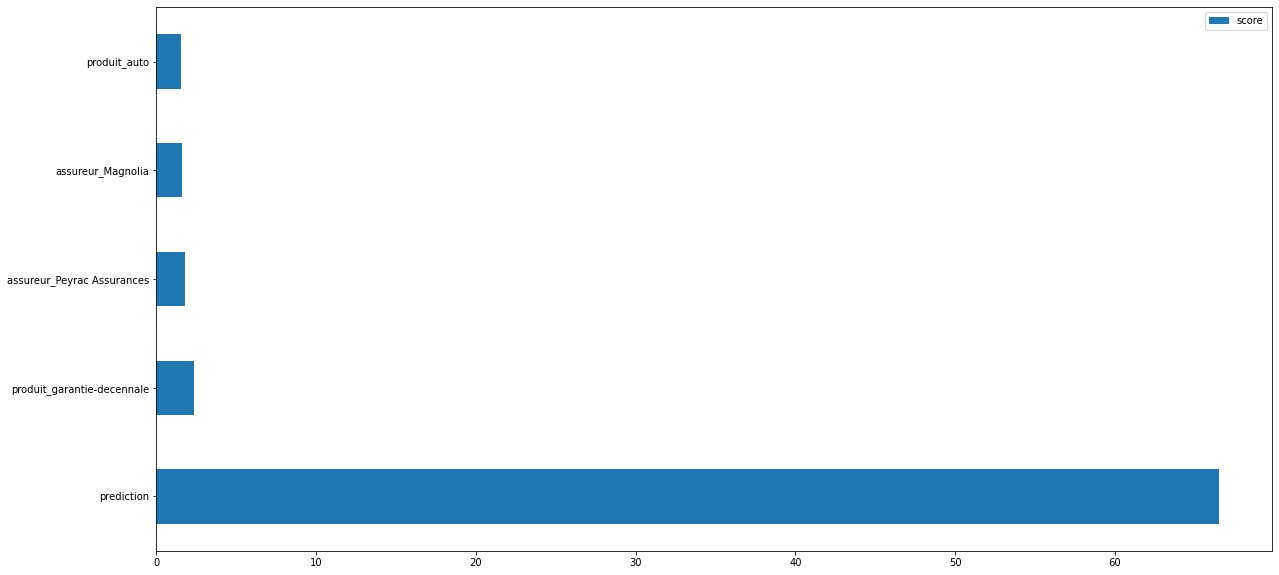

In [242]:
feature_important = model.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by="score", ascending=False)
data.nlargest(5, columns="score").plot(kind='barh', figsize = (20,10))

In [249]:
results_test = classifier(df_test["avis"].to_list(), padding=True, truncation=True)
result_test_stars = [int(x["label"][0]) for x in results_test]
#add column to df with predictions
df_test["prediction"] = result_test_stars
pd.options.display.max_colwidth = 120
df_test.head(10)

,date,auteur,avis,assureur,produit,prediction
0,2021-11-16,lognos-d-139728,Satisfait des tarif et rapide j'attends de voir avec le temp ce qu'on me proposera pour d'autre contrats auto logeme...,L'olivier Assurance,auto,4
1,2021-11-16,paugam-l-139727,"Bon service, service réactif. Tout en ligne pratique. Je recommanderai à l'un de mes proches si besoin. \r\nA voir s...",L'olivier Assurance,auto,4
2,2021-11-16,rozgonyi-o-139704,"L’assurance Olivier est une très bonne assurance j’en suis satisfaite , question qualité et prix cela me correspond...",L'olivier Assurance,auto,5
3,2021-11-16,saad-hellal-h-139697,Je suis satisfait de l'olivier assurances pas trop cher et le service client très sérieux simple est de prendre cont...,L'olivier Assurance,auto,5
4,2021-11-15,damis-s-139693,"le prix est attractif par rapport à ma situation , formules deux fois et demi moins cher pour une formule identique ...",L'olivier Assurance,auto,4
5,2021-11-15,beaudoux-t-139689,"Satisfait, de très bon conseils de la part du commercial et à l'écoute de mes demandes et propositions. Également tr...",L'olivier Assurance,auto,5
6,2021-11-15,cotin-j-139683,"Pour l'instant, pas eu de problème mon contrat commence qu'a partir du 28 novembre. Sinon votre service clients est ...",L'olivier Assurance,auto,4
7,2021-11-15,thiery-l-139681,"Je suis satisfaite de vos services, facile d'utilisation, prix très abordable. Réponse rapide et facile de compréhen...",L'olivier Assurance,auto,5
8,2021-11-15,royet-j-139672,Je suis satisfait du service et de la proposition commerciale la demande à était prise en compte rapidement je recom...,L'olivier Assurance,auto,4
9,2021-11-15,defez-a-139646,Prix correct et rapide rien à dire nous verrons par la suite si en cas de sinistre cet assureur ce montre rapide et ...,L'olivier Assurance,auto,5


In [250]:
df_test.to_csv("predictions_test.csv", index=False)

In [251]:
# feature engineering
# date field
df_test["year"] = df_test.date.apply(lambda x: x.year)
df_test["month"] = df_test.date.apply(lambda x: x.month)
df_test["day"] = df_test.date.apply(lambda x: x.day)
df_test["weekday"] = df_test.date.apply(lambda x: x.weekday())
df_test_with_pred = df_test.copy()
df_test_with_pred.drop(["date", "auteur", "avis"], axis=1, inplace=True)

# onehot encoding for assureur and produit
df_test_dummies = pd.get_dummies(df_test_with_pred)

In [252]:
X = df_dummies.drop(["note"], axis=1)
y = df_dummies["note"]

model = XGBClassifier(
    reg_alpha=20,
    reg_lambda=20,
    tree_method="hist",
    max_bin=512,
    subsample=0.8,
)

model.fit(X, y)
result_stars = model.predict(df_test_dummies)

C:\Users\Maxime\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [254]:
result_stars = [int(x) for x in result_stars]
# write to csv
df_test_with_pred["prediction"] = result_stars
df_test_with_pred.columns = [
    "assureur",
    "produit",
    "year",
    "month",
    "day",
    "weekday",
    "prediction",
]


In [255]:
df_test["prediction"] = result_stars
df_test.head(20)

In [258]:
df_test.tail(20)

,date,auteur,avis,assureur,produit,prediction,year,month,day,weekday
10312,2017-01-13,bd-4050,"Avec notre 1ere chienne, parcours du combattant pour être remboursés de sa 1ere intervention pour tumeur mammaire, p...",Eca Assurances,animaux,2,2017,1,13,4
10313,2016-12-13,marie-ant-50243,"Assurance animaux vraiment nul, ne rembourse pas pour ce qu'on a besoin. Sauf si on prend leurs assurances a 100e/mo...",Eca Assurances,animaux,1,2016,12,13,1
10314,2021-06-21,christian391-117720,"Les prix sont corrects, mais ce sont ceux que vous obtenez avec n'importe quel courtier. En revanche, si un jour vou...",MMA,responsabilite-civile-professionnelle,1,2021,6,21,0
10315,2020-11-24,mesmeilleuresarnaques-100553,Avis de client d'un professionnel du BTP assuré chez MMA. A la suite d'un dégât causé par ce constructeur lors d'un ...,MMA,responsabilite-civile-professionnelle,1,2020,11,24,1
10316,2020-12-11,catslab-101315,L'excellente interface commerciale laisse croire à l'utilité d'une assurance RC pro pour un auto-entrepreneur (posit...,Hiscox,responsabilite-civile-professionnelle,2,2020,12,11,4
10317,2020-11-23,freelance-100506,Attention à bien éplucher les c0nditions contractuelles intégralement.\r\nLes c0ntrats sont clairement c0nçus en vot...,Hiscox,responsabilite-civile-professionnelle,1,2020,11,23,0
10318,2021-01-22,laurent-103120,"Depuis le mois de Mars 2020 et ce fameux Covid, je ne peux plus exercer ma profession d'animateur auprès des collect...",Allianz,responsabilite-civile-professionnelle,1,2021,1,22,4
10319,2021-08-27,pascale--r-129733,Très bon contact. Toujours disponible. Toujours de bonnes explications du contrat. Toujours de bonnes solutions. Pr...,Mapa,multirisque-professionnelle,5,2021,8,27,4
10320,2021-07-22,manuel-r-124230,"personnel très compétent à l'agence de Reims , dommage que le siège ne s'aligne pas sur les tarifs de ces concurrent...",Mapa,multirisque-professionnelle,5,2021,7,22,3
10321,2021-09-10,gilauto-132326,LENTEUR ET DEFAUT DINFORMATION DANS LE REGLEMENT DE SINISTRE INCOHERENCE DANS LES REPONSES DE MES INTERLOCUTEURS APR...,Allianz,multirisque-professionnelle,1,2021,9,10,4


In [291]:
df_test_with_pred["prediction"].to_csv("predictions_final.csv", index=False)